In [17]:
import rasterio
import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

from unet_models import unet11

from test_unet_helpers import calcXYfromRC, checkWindow, gtDatasetSampler2, DigitalGlobeSamplerTensor

from utils import variable
from scipy import misc

from gbdxtools import Interface, CatalogImage




In [2]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../../union/union.shp' # desktop

with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [3]:
# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

In [11]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 2000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            #pr_start = ran_row*pan_factorR - side/2
            #pr_end = ran_row*pan_factorR + side/2
            #pc_start = ran_col*pan_factorC - side/2
            #pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            #coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 2000
generating sample 2 of 2000
generating sample 3 of 2000
generating sample 4 of 2000
generating sample 5 of 2000
generating sample 6 of 2000
generating sample 7 of 2000
generating sample 8 of 2000
generating sample 9 of 2000
generating sample 10 of 2000
generating sample 11 of 2000
generating sample 12 of 2000
generating sample 13 of 2000
generating sample 14 of 2000
generating sample 15 of 2000
generating sample 16 of 2000
generating sample 17 of 2000
generating sample 18 of 2000
generating sample 19 of 2000
generating sample 20 of 2000
generating sample 21 of 2000
generating sample 22 of 2000
generating sample 23 of 2000
generating sample 24 of 2000
generating sample 25 of 2000
generating sample 26 of 2000
generating sample 27 of 2000
generating sample 28 of 2000
generating sample 29 of 2000
generating sample 30 of 2000
generating sample 31 of 2000
generating sample 32 of 2000
generating sample 33 of 2000
generating sample 34 of 2000
generating sample 35 of

generating sample 286 of 2000
generating sample 287 of 2000
generating sample 288 of 2000
generating sample 289 of 2000
generating sample 290 of 2000
generating sample 291 of 2000
generating sample 292 of 2000
generating sample 293 of 2000
generating sample 294 of 2000
generating sample 295 of 2000
generating sample 296 of 2000
generating sample 297 of 2000
generating sample 298 of 2000
generating sample 299 of 2000
generating sample 300 of 2000
generating sample 301 of 2000
generating sample 302 of 2000
generating sample 303 of 2000
generating sample 304 of 2000
generating sample 305 of 2000
generating sample 306 of 2000
generating sample 307 of 2000
generating sample 308 of 2000
generating sample 309 of 2000
generating sample 310 of 2000
generating sample 311 of 2000
generating sample 312 of 2000
generating sample 313 of 2000
generating sample 314 of 2000
generating sample 315 of 2000
generating sample 316 of 2000
generating sample 317 of 2000
generating sample 318 of 2000
generating

generating sample 569 of 2000
generating sample 570 of 2000
generating sample 571 of 2000
generating sample 572 of 2000
generating sample 573 of 2000
generating sample 574 of 2000
generating sample 575 of 2000
generating sample 576 of 2000
generating sample 577 of 2000
generating sample 578 of 2000
generating sample 579 of 2000
generating sample 580 of 2000
generating sample 581 of 2000
generating sample 582 of 2000
generating sample 583 of 2000
generating sample 584 of 2000
generating sample 585 of 2000
generating sample 586 of 2000
generating sample 587 of 2000
generating sample 588 of 2000
generating sample 589 of 2000
generating sample 590 of 2000
generating sample 591 of 2000
generating sample 592 of 2000
generating sample 593 of 2000
generating sample 594 of 2000
generating sample 595 of 2000
generating sample 596 of 2000
generating sample 597 of 2000
generating sample 598 of 2000
generating sample 599 of 2000
generating sample 600 of 2000
generating sample 601 of 2000
generating

generating sample 859 of 2000
generating sample 860 of 2000
generating sample 861 of 2000
generating sample 862 of 2000
generating sample 863 of 2000
generating sample 864 of 2000
generating sample 865 of 2000
generating sample 866 of 2000
generating sample 867 of 2000
generating sample 868 of 2000
generating sample 869 of 2000
generating sample 870 of 2000
generating sample 871 of 2000
generating sample 872 of 2000
generating sample 873 of 2000
generating sample 874 of 2000
generating sample 875 of 2000
generating sample 876 of 2000
generating sample 877 of 2000
generating sample 878 of 2000
generating sample 879 of 2000
generating sample 880 of 2000
generating sample 881 of 2000
generating sample 882 of 2000
generating sample 883 of 2000
generating sample 884 of 2000
generating sample 885 of 2000
generating sample 886 of 2000
generating sample 887 of 2000
generating sample 888 of 2000
generating sample 889 of 2000
generating sample 890 of 2000
generating sample 891 of 2000
generating

generating sample 1146 of 2000
generating sample 1147 of 2000
generating sample 1148 of 2000
generating sample 1149 of 2000
generating sample 1150 of 2000
generating sample 1151 of 2000
generating sample 1152 of 2000
generating sample 1153 of 2000
generating sample 1154 of 2000
generating sample 1155 of 2000
generating sample 1156 of 2000
generating sample 1157 of 2000
generating sample 1158 of 2000
generating sample 1159 of 2000
generating sample 1160 of 2000
generating sample 1161 of 2000
generating sample 1162 of 2000
generating sample 1163 of 2000
generating sample 1164 of 2000
generating sample 1165 of 2000
generating sample 1166 of 2000
generating sample 1167 of 2000
generating sample 1168 of 2000
generating sample 1169 of 2000
generating sample 1170 of 2000
generating sample 1171 of 2000
generating sample 1172 of 2000
generating sample 1173 of 2000
generating sample 1174 of 2000
generating sample 1175 of 2000
generating sample 1176 of 2000
generating sample 1177 of 2000
generati

generating sample 1424 of 2000
generating sample 1425 of 2000
generating sample 1426 of 2000
generating sample 1427 of 2000
generating sample 1428 of 2000
generating sample 1429 of 2000
generating sample 1430 of 2000
generating sample 1431 of 2000
generating sample 1432 of 2000
generating sample 1433 of 2000
generating sample 1434 of 2000
generating sample 1435 of 2000
generating sample 1436 of 2000
generating sample 1437 of 2000
generating sample 1438 of 2000
generating sample 1439 of 2000
generating sample 1440 of 2000
generating sample 1441 of 2000
generating sample 1442 of 2000
generating sample 1443 of 2000
generating sample 1444 of 2000
generating sample 1445 of 2000
generating sample 1446 of 2000
generating sample 1447 of 2000
generating sample 1448 of 2000
generating sample 1449 of 2000
generating sample 1450 of 2000
generating sample 1451 of 2000
generating sample 1452 of 2000
generating sample 1453 of 2000
generating sample 1454 of 2000
generating sample 1455 of 2000
generati

generating sample 1710 of 2000
generating sample 1711 of 2000
generating sample 1712 of 2000
generating sample 1713 of 2000
generating sample 1714 of 2000
generating sample 1715 of 2000
generating sample 1716 of 2000
generating sample 1717 of 2000
generating sample 1718 of 2000
generating sample 1719 of 2000
generating sample 1720 of 2000
generating sample 1721 of 2000
generating sample 1722 of 2000
generating sample 1723 of 2000
generating sample 1724 of 2000
generating sample 1725 of 2000
generating sample 1726 of 2000
generating sample 1727 of 2000
generating sample 1728 of 2000
generating sample 1729 of 2000
generating sample 1730 of 2000
generating sample 1731 of 2000
generating sample 1732 of 2000
generating sample 1733 of 2000
generating sample 1734 of 2000
generating sample 1735 of 2000
generating sample 1736 of 2000
generating sample 1737 of 2000
generating sample 1738 of 2000
generating sample 1739 of 2000
generating sample 1740 of 2000
generating sample 1741 of 2000
generati

generating sample 1993 of 2000
generating sample 1994 of 2000
generating sample 1995 of 2000
generating sample 1996 of 2000
generating sample 1997 of 2000
generating sample 1998 of 2000
generating sample 1999 of 2000
generating sample 2000 of 2000


In [12]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [14]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
# with rasterio.open(gt_image_05, 'r') as src:

#     # cull the lon/lat points by checking if they include nodata pixels
#     gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]


In [15]:
# specify image transform for RGB image
img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

In [18]:
## establish the data loaders

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset = gtDatasetSampler2(gt_image_2, coords, transform=gt_transform) 
gt_dl = DataLoader(gt_dataset, batch_size=10, shuffle=False)

#DG
dg_dataset = DigitalGlobeSamplerTensor(img_2m, coords, transform=img_transform) # will return RGB by default
dg_dl = DataLoader(dg_dataset, batch_size=10, shuffle=False)

# Load the model and the model state from the .pt file. It may need to be downloaded from AWS S3

In [21]:
model_path = 'runs/debug/model_11.pt'
model = unet11(pretrained=False).cuda()
#load model
if os.path.exists(model_path):
    state = torch.load(str(model_path))
    epoch = state['epoch']
    step = state['step']
    model.load_state_dict(state['model'])
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))

Restored model, epoch 11, step 51


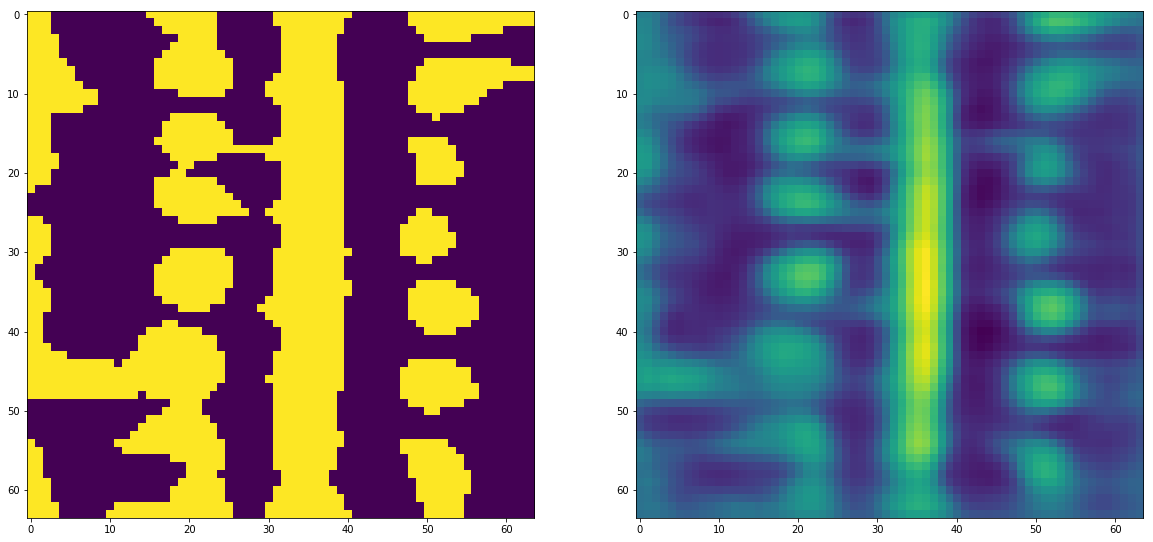

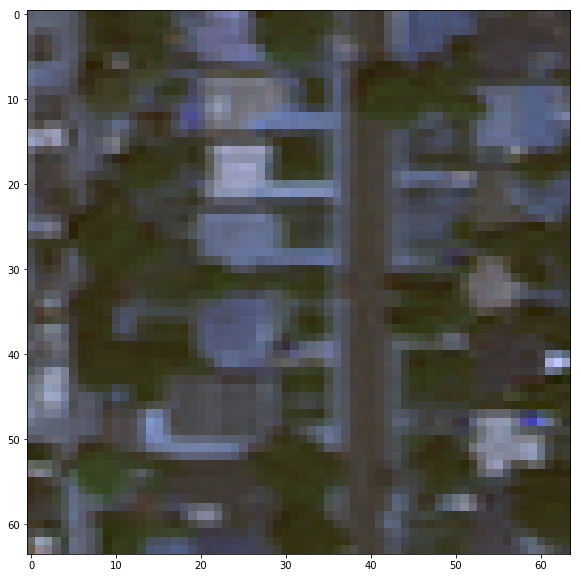

In [29]:

# check one of the test images
test_ind = 1000
input_img = torch.unsqueeze(variable(dg_dataset[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

fig, ax = plt.subplots(1,2, figsize=(20,10))
thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
ax[0].imshow(mask_binary)
# ax[0].colorbar()
gt_im = gt_dataset[test_ind].numpy().squeeze()
ax[1].imshow(mask_im)
# ax[1].colorbar()
plt.show()

plt.figure(figsize=(10,10))
source_im = dg_dataset[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()